In [1]:
import os
print(os.getcwd())

c:\Users\Ahmed\Desktop\AdvSecLab\advseceng25-sca-framework-main\src\py


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = np.load(r"C:\Users\Ahmed\Desktop\AdvSecLab\data\traces_0.npz")
print(data.files)
print(data['wave'].shape)
num_traces = data['wave'].shape[0]
trace_length = data['wave'].shape[1]

print(f"Number of traces: {num_traces}")
print(f"Trace length: {trace_length} samples")

['wave', 'dut_io_data', 'dut_io_computed_data']
(5000, 150)
Number of traces: 5000
Trace length: 150 samples


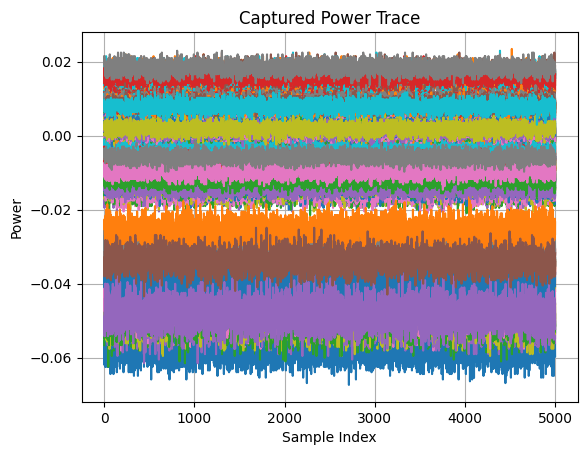

In [5]:
# Example: plot the waveform
waveform = data['wave']
plt.plot(waveform)
plt.title("Captured Power Trace")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.grid(True)
plt.show()

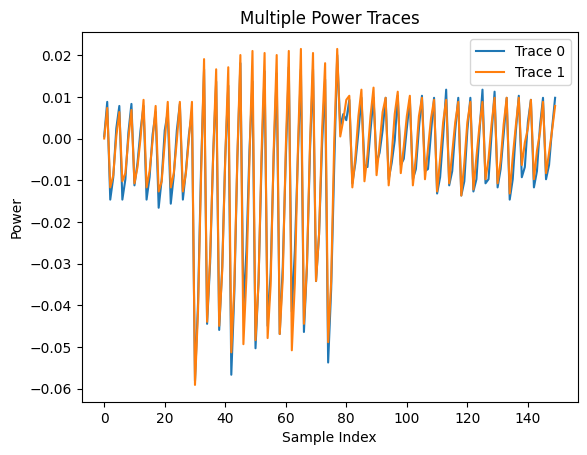

In [6]:
# multiple traces
for i in range(2):  # Plot first 2 traces
    plt.plot(data['wave'][i], label=f"Trace {i}")
plt.legend()
plt.title("Multiple Power Traces")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.show()

In [8]:
data = np.load("C:/Users/Ahmed/Desktop/AdvSecLab/data/traces_0.npz", allow_pickle=True)
print("Keys in .npz:", list(data.keys()))


Keys in .npz: ['wave', 'dut_io_data', 'dut_io_computed_data']


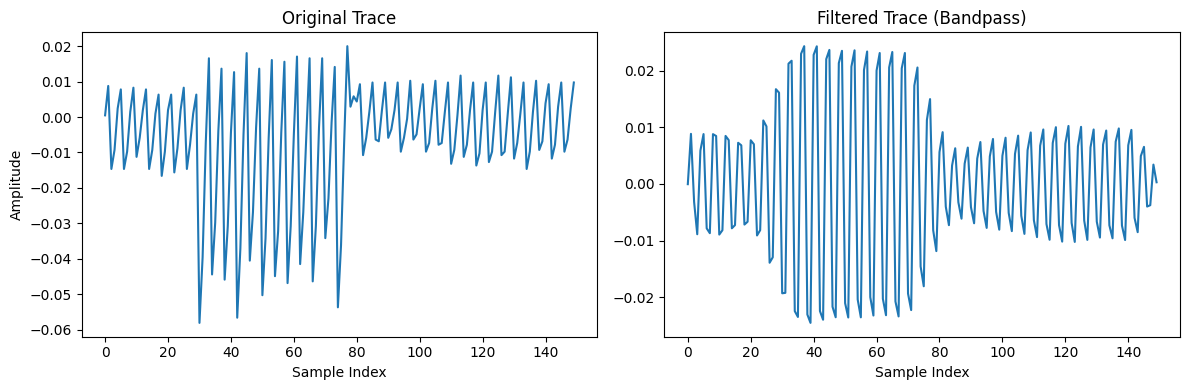

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Define the bandpass filter
def bandpass_filter(trace, lowcut=20e6, highcut=30e6, fs=100e6, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, trace)

# Load the .npz file
traces = data['wave']
dut_io_data = data['dut_io_data']
dut_io_computed_data = data['dut_io_computed_data']

# Apply the filter to all traces
filtered_traces = np.array([bandpass_filter(trace) for trace in traces])

# Plot one example trace (before and after filtering)
example_index = 0
original = traces[example_index]
filtered = filtered_traces[example_index]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(original)
plt.title("Original Trace")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)
plt.plot(filtered)
plt.title("Filtered Trace (Bandpass)")
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()

# Save filtered traces to a new file
np.savez_compressed(
    'data/traces_0_filtered.npz',
    wave=filtered_traces,
    dut_io_data=dut_io_data,
    dut_io_computed_data=dut_io_computed_data
)


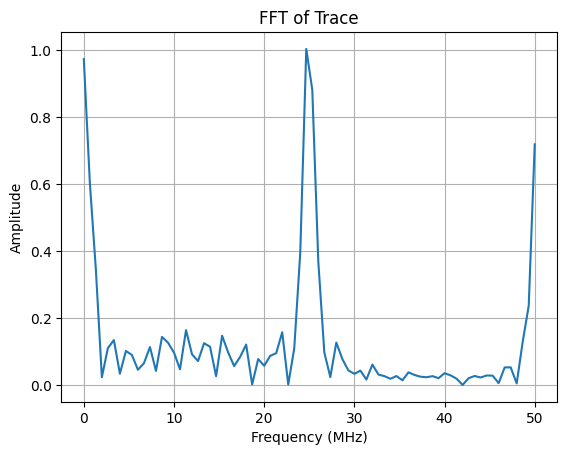

In [14]:
import numpy as np
import matplotlib.pyplot as plt

trace = data['wave'][0]  # Replace with your actual trace

fft_vals = np.abs(np.fft.rfft(trace))
fft_freqs = np.fft.rfftfreq(len(trace), d=1/100e6)

plt.plot(fft_freqs / 1e6, fft_vals)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Amplitude")
plt.title("FFT of Trace")
plt.grid(True)
plt.show()
